In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from utilities import (compute_derivatives_blur, build_rhs, of_cg,)


## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

Innledning

Oppgave 1?

Oppgave 2 intro

CG iter     1 | rel_res^2 = 1.368e+00
CG iter    50 | rel_res^2 = 5.388e-02
CG iter   100 | rel_res^2 = 3.358e-03
CG iter   150 | rel_res^2 = 2.178e-04
CG iter   200 | rel_res^2 = 1.499e-05
CG iter   250 | rel_res^2 = 1.775e-06
CG iter   300 | rel_res^2 = 1.365e-07
CG iter   350 | rel_res^2 = 1.071e-08
Done: iterations=352, final rel_res^2=9.952e-09


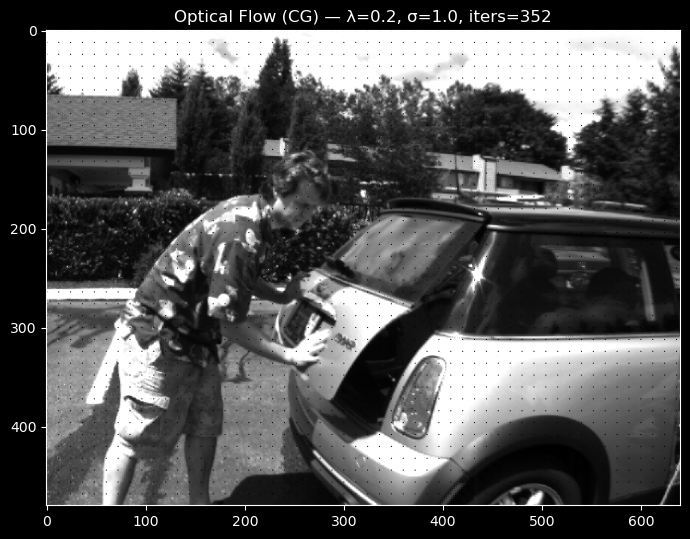

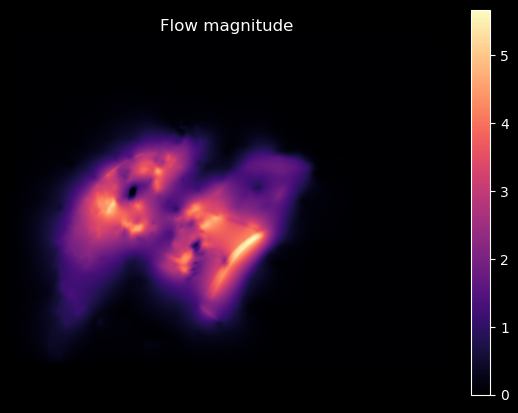

In [ ]:
def to_gray_float(a):
    a = a.astype(np.float32)
    if a.ndim == 3 and a.shape[2] >= 3:
        a = 0.2989 * a[..., 0] + 0.5870 * a[..., 1] + 0.1140 * a[..., 2]
    if a.max() > 1.5:
        a = a / 255.0
    return a

# %% inputs / params
frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"

lam   = 0.2     # try 0.05–0.5; larger spreads motion
tol   = 1e-8
maxit = 20000
sigma = 1.0     # set 0.0 to disable pre-blur for derivatives
step  = 12
scale = 80      # quiver scale (tune 40–200)

# %% load
I0 = to_gray_float(mpimg.imread(frame0_path))
I1 = to_gray_float(mpimg.imread(frame1_path))
assert I0.shape == I1.shape, "Frames must have the same shape"
h, w = I0.shape

# %% derivatives and RHS (with optional blur)
Ix, Iy, It = compute_derivatives_blur(I0, I1, sigma)
rhsu, rhsv = build_rhs(Ix, Iy, It)

# zero RHS on the 1-pixel border to respect Dirichlet
rhsu[0, :] = 0.0; rhsu[-1, :] = 0.0; rhsu[:, 0] = 0.0; rhsu[:, -1] = 0.0
rhsv[0, :] = 0.0; rhsv[-1, :] = 0.0; rhsv[:, 0] = 0.0; rhsv[:, -1] = 0.0

# %% initial guesses
u0 = np.zeros_like(I0, dtype=np.float32)
v0 = np.zeros_like(I0, dtype=np.float32)

# %% solve
def cb(k, rr2):
    if k == 1 or k % 50 == 0:
        print(f"CG iter {k:5d} | rel_res^2 = {rr2:.3e}")

u, v, it, rel = of_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit, callback=cb)
print(f"Done: iterations={it}, final rel_res^2={rel:.3e}")

# %% visualize (consistent image coordinates)
Y, X = np.mgrid[0:h:step, 0:w:step]

plt.figure(figsize=(7, 7))
plt.imshow(I0, cmap="gray", origin="lower")
plt.quiver(X, Y, u[::step, ::step], v[::step, ::step],
           angles="xy", scale_units="xy", scale=scale, width=0.002)
plt.gca().invert_yaxis()  # keep top-left as (0,0)
plt.title(f"Optical Flow (CG) — λ={lam}, σ={sigma}, iters={it}")
mag = np.hypot(u, v)
plt.imshow(mag, cmap="magma")
plt.colorbar(); plt.title("Flow magnitude"); plt.axis("off")
plt.tight_layout()
plt.show()

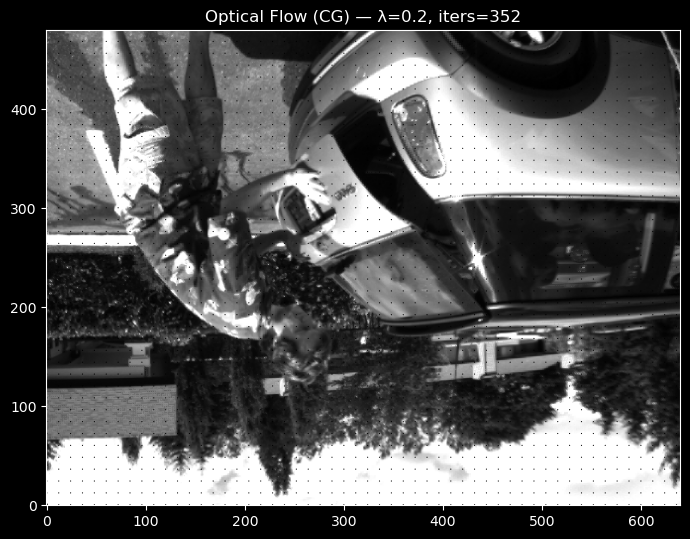

In [29]:
Y, X = np.mgrid[0:u.shape[0]:step, 0:u.shape[1]:step]

plt.figure(figsize=(7, 7))
plt.imshow(I0, cmap="gray")
plt.quiver(X, Y, u[::step, ::step], v[::step, ::step],
           angles="xy", scale_units="xy", scale=80, width=0.002)  # add a scale (e.g., 60–120)
plt.gca().invert_yaxis()
plt.title(f"Optical Flow (CG) — λ={lam}, iters={it}")
plt.tight_layout()
plt.show()
